In [40]:
import networkx as nx 
import random
import matplotlib.pyplot as plt
import numpy as np 
import math 
import copy 
import graphviz
from scipy.optimize import fsolve
from typing import List
import sympy as sp
from sympy import Symbol
from collections import deque

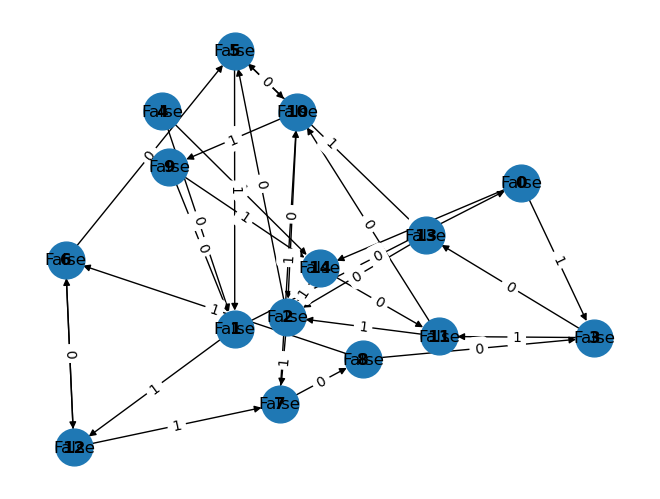

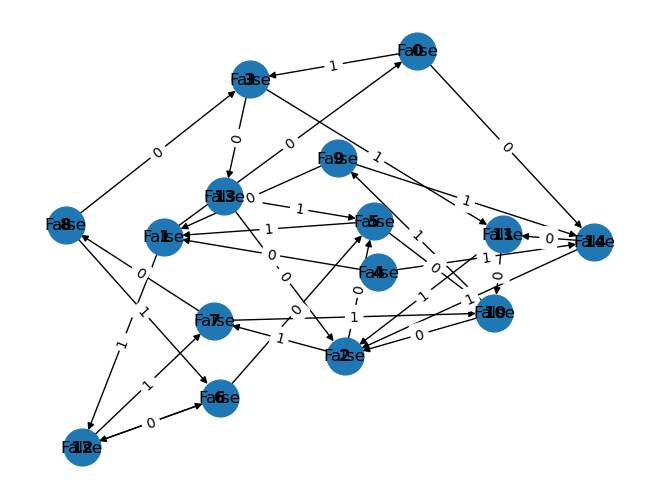

In [81]:
class Arrival():
    
    def __init__(self,n):
        self.n = n # number of nodes
        self.vertices = [v for v in range(n)] # zero is origin and n is the destination 
        self.s_0 = np.array([random.choice([i for i in range(n) if i != v]) for v in self.vertices])  # even successors
        self.s_1 = np.array([random.choice([i for i in range(n) if i != v]) for v in self.vertices])  # odd successors
      
        # Some edges can have both successor as themselves, acting as sinks. should this be allowed??
        self.s_curr = np.copy(self.s_0) # current switches for each node
        self.s_next = np.copy(self.s_1) # next switch for each node
        self.v = 0 # current node 
        self.target_node = self.vertices[-1]
        # self.plot_graph('untrimmed.gv')
        # self.trim_dead_ends()
        self.graph = self.get_network_graph()
        self.draw_graph()
        
        self.combine_unreachable_nodes()
        self.draw_graph()
        
        # self.equations = self.get_equations()
        
    def __repr__(self):
        return f"Even Successors: {self.s_0}\nOdd Successors: {self.s_1}\nCurrent Switches: {self.s_curr}\nNext Switches: {self.s_next}\nCurrent Node: {self.v}"
    
    def next_node(self,v):
        assert v < self.n
        next = self.s_curr[v]
        self.s_curr[v] = self.s_next[v]
        self.next[v] = next
        return next
    
    def plot_graph(self,filename):
        g = graphviz.Digraph('G', filename=filename)
        # g.edges(self.vertices)
        for v in range(self.n):
            g.edge(str(v),str(self.s_0[v]),label='0')
            g.edge(str(v),str(self.s_1[v]),label='1')
            
        g.view()
        
    def get_network_graph(self):
        G = nx.DiGraph()
        G.add_nodes_from(self.vertices, d_dash=False)
        
        for v in self.vertices:
            G.add_edge(v,self.s_0[v],label='0')
            G.add_edge(v,self.s_1[v],label='1')
            
        return G
    
    def draw_graph(self):
        pos = nx.spring_layout(self.graph)
        edge_labels = nx.get_edge_attributes(self.graph, 'label')
        node_labels = nx.get_node_attributes(self.graph, 'd_dash')
        nx.draw(self.graph,pos, with_labels=True, font_weight='bold', node_size=700)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels)
        # nx.draw_networkx_labels(self.graph, pos, labels=node_labels)
        
        plt.show()
        
    def combine_unreachable_nodes(self):
        # reachable_nodes = nx.descendants(self.graph, self.target_node) | {self.target_node}
        reachable_nodes = nx.ancestors(self.graph, self.target_node) | {self.target_node}

        for node in self.graph.nodes():
            if node not in reachable_nodes:
                self.graph.nodes[node]['d_dash'] = True


    def get_equations(self):
        self.X = sp.symbols(' '.join([f"X{i}" for i in range(self.n)]),positive=True)
        
        self.equations = []
        for v in range(self.n):
            odd_parents = np.where(self.s_1 == v)[0]
            even_parents = np.where(self.s_0 == v)[0]
            
            parent_sum = sp.sympify(0)
            for p in odd_parents:
                parent_sum += sp.floor(self.X[p]/2)
            for p in even_parents:
                parent_sum += sp.ceiling(self.X[p]/2)
            # parent_sum = sum([math.floor(X[p]/2) for p in odd_parents]) + sum([math.ceil(X[p]/2) for p in even_parents])
            # eq = X[v] - (parent_sum + 1) if v == 0 else X[v] - parent_sum # origin is visited one more time
            total_sum = (parent_sum + 1) if v == 0 else parent_sum # origin is visited one more time
            eq = sp.Min(total_sum,self.n*(2**self.n))
            self.equations.append(eq)
            
        return self.X,self.equations
    
    def evaluate(self,x):
        assert len(x) == self.n
        # make sympy assignments of given values 
        assignment = {self.X[i]: value_i for i, value_i in enumerate(x)}
        
        results = []
        for eq in self.equations:
            # substitute assignments in equations
            result = eq.subs(assignment)
            results.append(result)
        
        return np.array(results)
            
    
##### driver code 
a = Arrival(15)

# # print(a.s_0)
# a.plot_graph('arrival.gv')